In [1]:
from ghost.phantom import Caliber137
import ants
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
import pandas as pd

from ghost.utils import calc_psnr, calc_ssim, calc_snr_diff

%load_ext autoreload
%autoreload 2

In [2]:
def add_rician_noise(data, sd, rng):
    noise = rng.normal(0, sd, [*data.shape, 2])
    return np.sqrt( abs(data + noise[...,0])**2 + abs(1j*noise[...,1])**2)

In [3]:
phantom = Caliber137()

fname = phantom.get_phantom_nii(weighting='T2w')
data = ants.image_read(fname)

fname = phantom.get_seg_nii('phantomMask')
seg = ants.image_read(fname)

fname = phantom.get_seg_nii('BG')
BG = ants.image_read(fname)

In [4]:
data_rs = ants.resample_image(data, [1.5, 1.5, 5], interp_type=0, use_voxels=False).numpy()
data_rs /= np.max(data_rs)

seg_rs = ants.resample_image(seg, [1.5, 1.5, 5], interp_type=1, use_voxels=False).numpy()
seg_rs[seg_rs==0] = np.nan

BG_rs = ants.resample_image(seg, [1.5, 1.5, 5], interp_type=1, use_voxels=False).numpy()
BG_rs[BG_rs==0] = np.nan

# Crop images
data_rs = data_rs[25:-25, 25:-25, 1:-4]
seg_rs = seg_rs[25:-25, 25:-25, 1:-4]
BG_rs = BG_rs[25:-25, 25:-25, 1:-4]

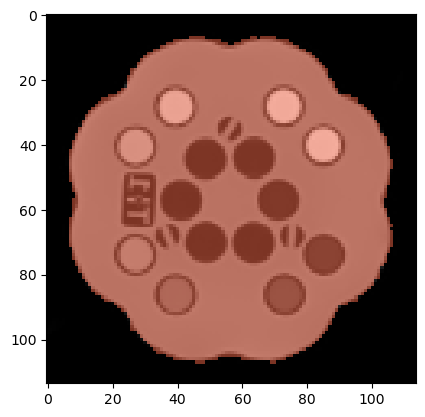

In [8]:
plt.figure()
plt.imshow(data_rs[:,:,20], cmap='gray', vmin=0, vmax=1)
plt.imshow(seg_rs[:,:,20], cmap='Reds', vmin=0, vmax=2, alpha=0.5)

In [33]:
rng = np.random.default_rng(seed=42)

noise_levels = np.linspace(5,100)
n_iter = 100

mat_psnr = np.zeros([n_iter, len(noise_levels)])
mat_psnr_ref = np.zeros_like(mat_psnr)
mat_ssim = np.zeros_like(mat_psnr)
mat_ssim_ref = np.zeros_like(mat_psnr)
mat_snr = np.zeros_like(mat_psnr)

for i,s in tqdm(enumerate(noise_levels)):
    for k in range(n_iter):
        img1 = add_rician_noise(data_rs, 1/s, rng)
        img2 = add_rician_noise(data_rs, 1/s, rng)

        MSE, PSNR = calc_psnr(img1, img2, seg_rs)
        _, PSNR_ref = calc_psnr(data_rs, img2, seg_rs)

        SNR = calc_snr_diff(img1, img2, BG_rs)
        mSSIM = calc_ssim(img1, img2, seg_rs)
        mSSIM_ref = calc_ssim(data_rs, img2, seg_rs)

        mat_ssim[k,i] = mSSIM
        mat_ssim_ref[k,i] = mSSIM_ref
        mat_psnr[k,i] = PSNR
        mat_psnr_ref[k,i] = PSNR_ref
        mat_snr[k,i] = SNR
        

50it [06:08,  7.37s/it]


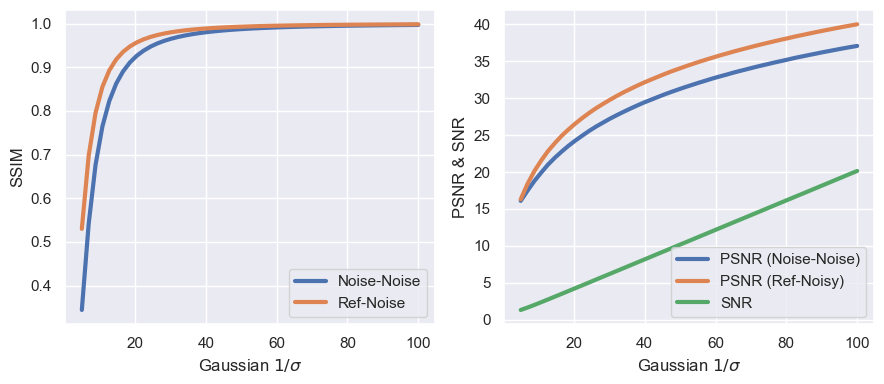

In [34]:
sns.set_theme()

fig, axes = plt.subplots(1,2,figsize=(9,4))
ax = axes[0]
ax.plot(noise_levels, np.mean(mat_ssim, axis=0), linewidth=3, label='Noise-Noise')
ax.plot(noise_levels, np.mean(mat_ssim_ref, axis=0), linewidth=3, label='Ref-Noise')

ax.set_ylabel("SSIM")

ax = axes[1]
ax.plot(noise_levels, np.mean(mat_psnr, axis=0), linewidth=3, label='PSNR (Noise-Noise)')
ax.plot(noise_levels, np.mean(mat_psnr_ref, axis=0), linewidth=3, label='PSNR (Ref-Noisy)')
ax.plot(noise_levels, np.mean(mat_snr, axis=0), linewidth=3, label='SNR')

ax.set_ylabel('PSNR & SNR')

for ax in axes:
    ax.set_xlabel(r'Gaussian $1/\sigma$')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()